In [4]:
%matplotlib inline

#LIBRARY IMPORTS AND CONFIGURATIONS
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import theano.tensor as tt
from pymc3.math import logsumexp
from theano.tensor.nlinalg import det


167 datapoints for feature # 1
25 datapoints for feature # 8
k is not 0!


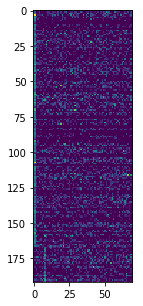

In [5]:
#MAKE SOME FAKE DATA

N = 100 #MEAN NUMBER OF DATAPOINTS

C = 70 #TOTAL NUMBER OF FEATURES (CATEGORIES, FAILURE MECHANISMS)

mean_number_of_failing_features = C * 0.1

K = 2 #NUMBER OF DIFFERENT UNDERLYING FEATURES 
datapoints_for_this_mixture_component = np.zeros(K, dtype=int)
true_feature_columns = np.empty(K,dtype=int)


for k in np.arange(K):
    while datapoints_for_this_mixture_component[k]<=0:
        datapoints_for_this_mixture_component[k] = int(np.random.normal(N, 50))
    true_feature_columns[k] = np.random.randint(0,C)
    
    print("%d datapoints for feature # %d" % (datapoints_for_this_mixture_component[k],true_feature_columns[k]))

    if k==0:
        start=0
        y = np.zeros([datapoints_for_this_mixture_component[k],C])
        number_of_failing_features_this_datapoint = np.zeros(datapoints_for_this_mixture_component[k])
    else:
        print("k is not 0!")
        start=datapoints_for_this_mixture_component[k-1]
        y=np.append(y, np.zeros([datapoints_for_this_mixture_component[k],C]),axis=0)
        number_of_failing_features_this_datapoint = np.append(number_of_failing_features_this_datapoint,np.zeros(datapoints_for_this_mixture_component[k]),axis=0)
        
        
    #FOR EACH DATAPOINT
    for n in range(start,start+datapoints_for_this_mixture_component[k]):
       
        number_of_failing_features_this_datapoint[n] = np.random.randint(0,C)
        
        for ff in np.arange(number_of_failing_features_this_datapoint[n]):
            
            random_failing_feature = np.random.randint(0,C,dtype=int)
            y[n,random_failing_feature]+=np.random.gamma(5, scale=1.0)
            
        y[n,true_feature_columns[k]]+=int(np.random.triangular(0,20,20))


#print(y)
fig = plt.figure(figsize=(5,5))
# Define gridspec
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0])

imgplot = ax1.imshow(y)
#fig.colorbar()
np.savetxt("example_data.csv", y, delimiter=",")

some_arbitrary_noise_columns=np.array([1])

X = y[:,np.concatenate([true_feature_columns,some_arbitrary_noise_columns])]


In [94]:
K = 2. #CLUSTERS

# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * tt.log(2 * np.pi) + tt.log(1./det(tau)) +
                         (delta(mu).dot(tau) * delta(mu) + tt.nnet.softmax(mu)).sum(axis=1))

# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau):
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value) 
                 for i, mu in enumerate(mus)]

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

with pm.Model() as model:
    mus = [pm.MvNormal('mu_%d' % i,
                    mu=pm.floatX(np.zeros(X.shape[1])),
                    tau=pm.floatX(0.1 * np.eye(X.shape[1])),
                    shape=(X.shape[1],))
           for i in range(int(K))]
    pi = pm.Dirichlet('pi', a=pm.floatX(0.1 * np.ones(int(K))), shape=(int(K),))
    xs = pm.DensityDist('x', logp_gmix(mus, pi, np.eye(X.shape[1])), observed=X)

In [76]:
iii, muuu = enumerate(mus)
print(iii)
print(muuu)

(0, mu_0)
(1, mu_1)


In [95]:
with model:
    trace = pm.fit(n=10000, obj_optimizer=pm.adagrad(learning_rate=1e-1))
    #trace = pm.sample(draws=1000, tune=200)

#pm.traceplot(trace, varnames=['p'], lines=dict(p=preal))

Average Loss = 3,937.2: 100%|███████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 766.97it/s]
Finished [100%]: Average Loss = 3,935.4


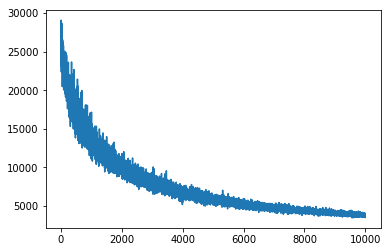

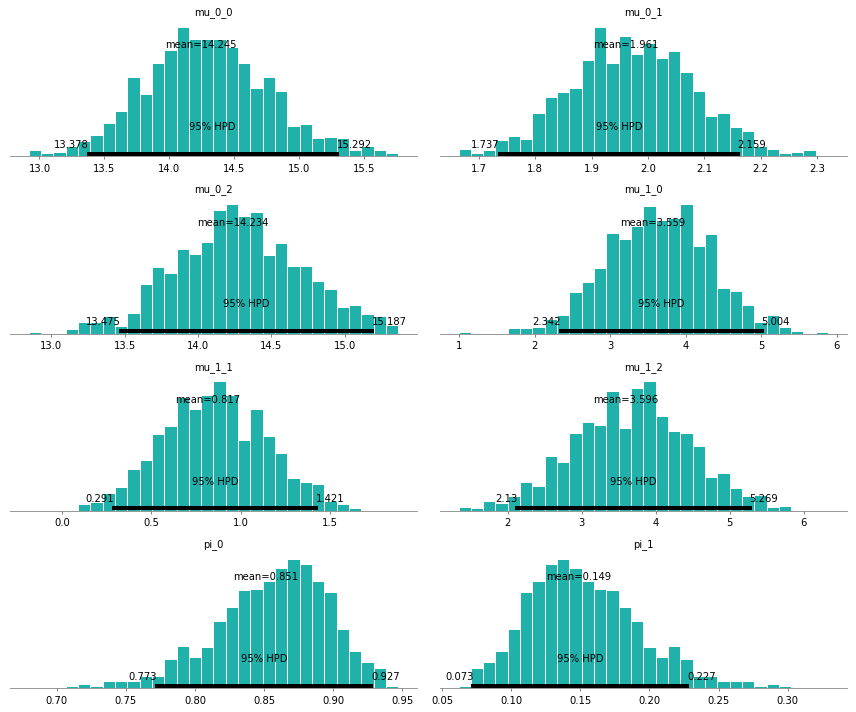

In [96]:
plt.plot(trace.hist)
pm.plot_posterior(trace.sample(1000), color='LightSeaGreen');

In [23]:

import sys, IPython, scipy, matplotlib, platform
if platform.system() == "Windows":
    distro = ' '.join(platform.win32_ver()[:])
elif platform.system() == "Linux":
    distro = join(platform.linux_distribution()[:2])
print("This notebook was created on a computer %s running %s %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), platform.system(), distro, sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was created on a computer AMD64 running Windows 7 6.1.7601 SP1 Multiprocessor Free and using:
Python 3.6.3
IPython 6.1.0
PyMC3 3.2
NumPy 1.13.3
SciPy 0.19.1
Matplotlib 2.1.0
Seaborn 0.8.0

